<a href="https://colab.research.google.com/github/juergenlandauer/caa2025/blob/main/PotsherdDetection/CAA2025_Potsherd_detection_drone_SAM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Automatic potsherd detection in videos with SAM (Segment Anything Model by Meta AI)
Author: Juergen Landauer (juergen AT landauer-ai.de)

To start, first go to the "Input parameters" section below and review or (optionally) adjust parameters. Then run the entire Notebook by choosing Runtime->Run all in the menu above.

### Install SAM2 and dependencies

We first install Meta's SAM, Roboflow's Supervision and other libraries, then the SAM model weights. This could take up to 5 minutes.

In [ ]:
!pip install -Uq opencv-python supervision
!pip install -Uq 'git+https://github.com/facebookresearch/sam2.git'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.8 MB/s eta 0:00:00


### Caution!
You might get asked to restart this session here. This is mandatory.

In [ ]:
# download SAM weights
!mkdir -p ../checkpoints/
#!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt

--2025-04-15 09:51:12--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.51, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184416285 (176M) [application/vnd.snesdev-page-table]
Saving to: ‘../checkpoints/sam2.1_hiera_small.pt’

sam2.1_hiera_small. 100%[===================>] 175.87M   198MB/s    in 0.9s    

2025-04-15 09:51:13 (198 MB/s) - ‘../checkpoints/sam2.1_hiera_small.pt’ saved [184416285/184416285]



# Input parameters

Review all parameters in this section and (optionally) adjust them on the right side. For example, you can upload your own input zip file by providing an URL.

In [ ]:
# demo video frames for CAA2 025
# feel free to replace this with your own imagery by providing a download URL (e.g. from Google Drive)
# Note that the ZIP file must contain only images in its root folder. No sub-directories!

INPUT_ZIP_URL = 'https://www.dropbox.com/scl/fi/u0htcr0kllnohu7hwsfox/DroneVideo.zip?rlkey=zxj171l892fgogi4mo8h5ej8e&st=33q8o1ka&dl=0' # @param {"allow-input":true}

**Important Note:** If you run your video for the first time, you might want to play with the hue and area range parameters below. This is because your particular type(s) of pottery may have deviating color (hue) values. This process is called calibration.

Only one or a few video frames (images) are sufficient for that process.

To make this easier, the software has a calibration mode, which you can turn on or off here. It will output your image(s) also with hue values for each detection in a separate ZIP file.

Later you might want to turn it off for performance reasons and run your entire video.

In [ ]:
Calibration_Mode = True # @param ["True", "False"]

In [ ]:
hue_from = 10 # @param {"allow-input":true}
hue_to = 17   # @param {"allow-input":true}
HUE_RANGE = (hue_from, hue_to)

In [ ]:
HUE_RANGE = (8, 16) # for Aptera
HUE_RANGE = (8, 25)# for Aptera

In [ ]:
Area_from = 8 # @param {"allow-input":true}
Area_to = 500   # @param {"allow-input":true}
AREA_RANGE = (Area_from, Area_to)

In [ ]:
AREA_RANGE = (0, 500)
AREA_RANGE = (200, 10000) # Aptera
AREA_RANGE = (100, 3000) # Aptera

In [ ]:
# do you want output whileprocessing (here in the Colab console)? Recommended
With_console_output = True # @param ["True", "False"]

In [ ]:
# do you want the number of sherds per image written on the output images?
Show_number_sherds_on_output = True# @param ["True", "False"]

### Now we import some libraries

In [ ]:
import os
import gc
import cv2
import base64
from glob import glob
from pathlib import Path
import numpy as np
import supervision as sv
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import files as colabfiles

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [ ]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Let's load the model





In [ ]:
# We use the small SAM model. Do not forget to edit here if you want to use another one!
DEVICE = torch.device('cuda')
CHECKPOINT = "../checkpoints/sam2.1_hiera_small.pt"
CONFIG = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

## We load the data (video frames or orthophoto) and unzip it into the directory 'input'

In [ ]:
!rm -rf input output file.zip
!mkdir -p input/
!wget -O file.zip "$INPUT_ZIP_URL"
!unzip file.zip -d input

--2025-04-15 09:51:33--  https://www.dropbox.com/scl/fi/dovk2mw8eaqvg52bzt87y/testApteraMiniLowres.zip?rlkey=l8h23ogzlmu0b0fvremqaud48&st=t5hxelch&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3fe14084d7f03e93578da89545.dl.dropboxusercontent.com/cd/0/inline/Cn0LXgu23jRWGGtAbsZcZSnAdlXqcc5jphwq-J2OjN7m32d1XJ_IipFpjJrFrk-BkSd2xzfbIjzajr6HFU6Ym2S0b8VuY5mqT3q8U1dYHKdLN-n3tQ0bchu3w2bjKiBf4dE/file# [following]
--2025-04-15 09:51:34--  https://uc3fe14084d7f03e93578da89545.dl.dropboxusercontent.com/cd/0/inline/Cn0LXgu23jRWGGtAbsZcZSnAdlXqcc5jphwq-J2OjN7m32d1XJ_IipFpjJrFrk-BkSd2xzfbIjzajr6HFU6Ym2S0b8VuY5mqT3q8U1dYHKdLN-n3tQ0bchu3w2bjKiBf4dE/file
Resolving uc3fe14084d7f03e93578da89545.dl.dropboxusercontent.com (uc3fe14084d7f03e93578da89545.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a

### Results visualisation helper functions

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX, color=sv.Color.RED)

def annotateMask(image_bgr, detections):
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    return annotated_image

In [ ]:
round_box_annotator = sv.RoundBoxAnnotator(color_lookup=sv.ColorLookup.INDEX, color=sv.Color.RED)

def annotateBox(image_bgr, detections):
    annotated_image = round_box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    return annotated_image

In [ ]:
box_corner_annotator = sv.BoxCornerAnnotator(color_lookup=sv.ColorLookup.INDEX, color=sv.Color.RED, thickness=1, corner_length=6)

def annotateBoxCorner(image_bgr, detections):
    annotated_image = box_corner_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    return annotated_image

In [ ]:
dot_annotator = sv.DotAnnotator(color_lookup=sv.ColorLookup.INDEX, color=sv.Color.RED, radius=2)

def annotateDot(image_bgr, detections):
    annotated_image = dot_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    return annotated_image

In [ ]:
label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER, color_lookup=sv.ColorLookup.INDEX, color=sv.Color.RED)

def annotateHue(image_bgr, detections):
    annotated_image = label_annotator.annotate(scene=image_bgr.copy(), detections=detections,
                                               labels=list(map(str, detections['hue'])))
    return annotated_image

If desired you can implement a filter function here in order to filter your input images. This is optional

In [ ]:
def preprocessSnippetNONE(image: np.ndarray): return image

In [ ]:
filter = preprocessSnippetNONE

### Functions for reading images and processing

In [ ]:
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(pow(2,40)) # for very large images

In [ ]:
def image_tiler(image_path, tile_size=(512, 512)):
    """
    Splits an image into tiles of a specified size, yielding them one by one.
    Pads tiles smaller than tile_size with black pixels.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return

    img_h, img_w = img.shape[:2]
    tile_h, tile_w = tile_size

    for y in range(0, img_h, tile_h):
        for x in range(0, img_w, tile_w):
            tile = img[y:min(y + tile_h, img_h), x:min(x + tile_w, img_w)]

            # Pad the tile if necessary
            padded_tile = np.zeros((tile_h, tile_w, 3), dtype=np.uint8)
            tile_h_pad, tile_w_pad = tile.shape[:2]

            padded_tile[:tile_h_pad, :tile_w_pad, :] = tile

            yield img_w, img_h, x, y, tile.shape, padded_tile

In [ ]:
def compute_mean_color_with_mask_hsv(image, mask):
    """Computes the mean color of a HSV image within a given mask.

    Args:
        image: The input image as a NumPy array (BGR format).
        mask: The binary mask as a NumPy array.

    Returns:
        A tuple representing the mean BGR color (mean_b, mean_g, mean_r).
        Returns None if the mask is empty.
    """

    # Ensure the mask and image have the same shape
    if image.shape[:2] != mask.shape: raise ValueError("Image and mask dimensions must match")

    # Get the indices where the mask is non-zero
    mask_indices = np.where(mask != 0)

    if not mask_indices[0].size:  # Check if mask is empty
      return None

    # Extract the HSV color values at the masked indices
    masked_h = image[mask_indices][:, 0]
    masked_s = image[mask_indices][:, 1]
    masked_v = image[mask_indices][:, 2]

    # Calculate the mean color values
    mean_h = np.mean(masked_h).astype(np.uint8)
    mean_s = np.mean(masked_s).astype(np.uint8)
    mean_v = np.mean(masked_v).astype(np.uint8)

    return (mean_h, mean_s, mean_v)

### Filtering SAM results
based on area and color (hue), then applying Non-Maximum Suppression (NMS) to avoid overlapping results.

In [ ]:
# returns a filtered sam2 result, optionally stores snippets as a side effect
def filter_result(img, sam2_result, hue_range=(10,17)):
    # prepare
    hsv_img   = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # put into dataframe
    result_df = pd.DataFrame(sam2_result)
    print ("before all filters:", len(result_df))

    # filter by area
    print ("--> filter areas (min max) = (", result_df.area.min(), result_df.area.max(), result_df.area.mean(), ") / below ", AREA_RANGE[1],":", len(result_df[result_df.area < AREA_RANGE[1]]))
    result_df = result_df[AREA_RANGE[0] <= result_df.area]
    result_df = result_df[result_df.area <= AREA_RANGE[1]]
    print ("after area filter:", len(result_df))

    # filter by  HUE
    h_from, h_to = hue_range
    result_df['hue'] = -1
    result_df['sat'] = -1
    for index, row in result_df.iterrows():
        hue, sat, val = compute_mean_color_with_mask_hsv(hsv_img, row.segmentation)
        result_df.at[index, 'hue'] = hue
        result_df.at[index, 'sat'] = sat

    # if failed hue test -> drop them
    result_df = result_df[(result_df.hue >= h_from) & (result_df.hue <= h_to)]
    print ("remaining after hue filter", len(result_df))

    if (len(result_df) > 0):
        # convert into sv.Detections and apply NMS
        xyxy       = sv.xywh_to_xyxy(xywh=np.array(result_df['bbox'].values.tolist(), dtype=np.uint16))
        confidence = np.array(result_df['predicted_iou'].values.tolist())
        masks      = np.array(result_df['segmentation'].values.tolist()) # masks are too slow, use boxes instead
        detections = sv.Detections(xyxy=xyxy, data={'items': masks,
                                                    'hue': list(result_df.hue),
                                                    'sat': list(result_df.sat),
                                                    'bbox': list(result_df.bbox),
                                                    }, confidence=confidence)
        print ("before NMS", len(detections))
        detections = detections.with_nms(class_agnostic=True)
        detections.mask = detections.data['items'] # re-insert the masks
        print ("remaining after NMS", len(detections))
    else: detections = []

    return detections

## process folder

In [ ]:
OUTPATH = Path("./output")
os.makedirs(OUTPATH, exist_ok=True)

files = sorted(glob('input/*.*'))
len(files)

1

In [ ]:
# limit files list to some files only for debugging if desired
#files = files[60:80]
#files = files[100:110]
#files

In [ ]:
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64, # this controls the quality of the output. Increase this value if output quality is insufficient (if you do not get out-of-memory errors through this)-
    points_per_batch=96,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    #crop_n_points_downscale_factor=2,
    #min_mask_region_area=15,
)

In [ ]:
# choose other annotation graphics if desired by uncommenting below
# Recommended:
# Mask: shows outline of potsherds
# Box = shows bounding box of potsherds

#annotatorFunc = annotateMask
annotatorFunc = annotateBox
#annotatorFunc = annotateBoxCorner
#annotatorFunc = annotateDot

input/testApteraMiniLowres.png 1684 871 0 0
before all filters: 168
--> filter areas (min max) = ( 13 257252 1721.5654761904761 ) / below  3000 : 166
after area filter: 73
remaining after hue filter 18
before NMS 18
remaining after NMS 15


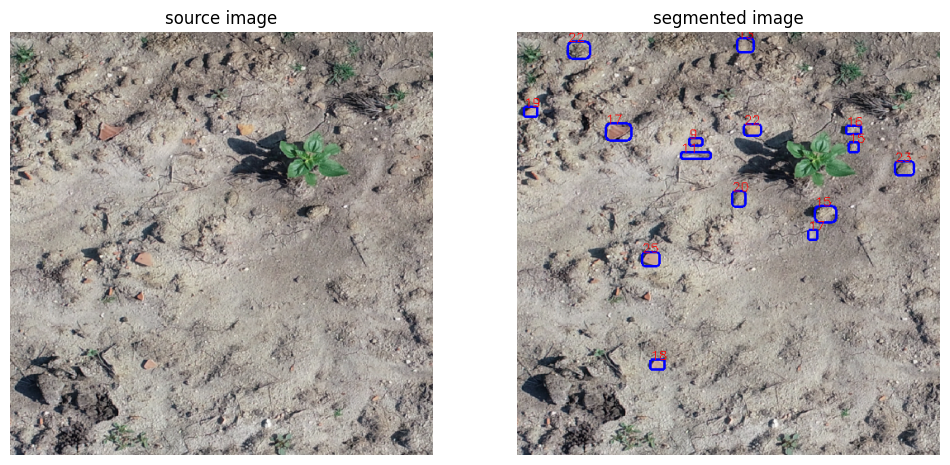

input/testApteraMiniLowres.png 1684 871 512 0
before all filters: 252
--> filter areas (min max) = ( 6 259458 1223.781746031746 ) / below  3000 : 251
after area filter: 142
remaining after hue filter 47
before NMS 47
remaining after NMS 39


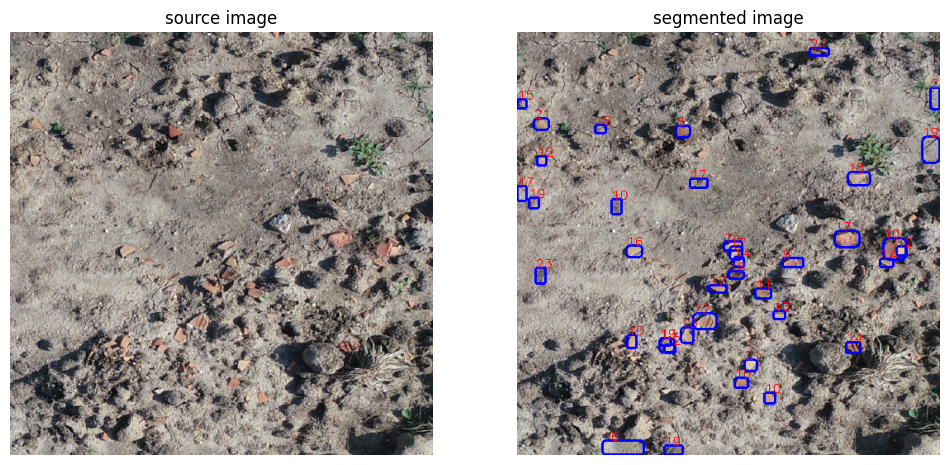

input/testApteraMiniLowres.png 1684 871 1024 0
before all filters: 193
--> filter areas (min max) = ( 13 257683 1610.6476683937824 ) / below  3000 : 192
after area filter: 142
remaining after hue filter 28
before NMS 28
remaining after NMS 22


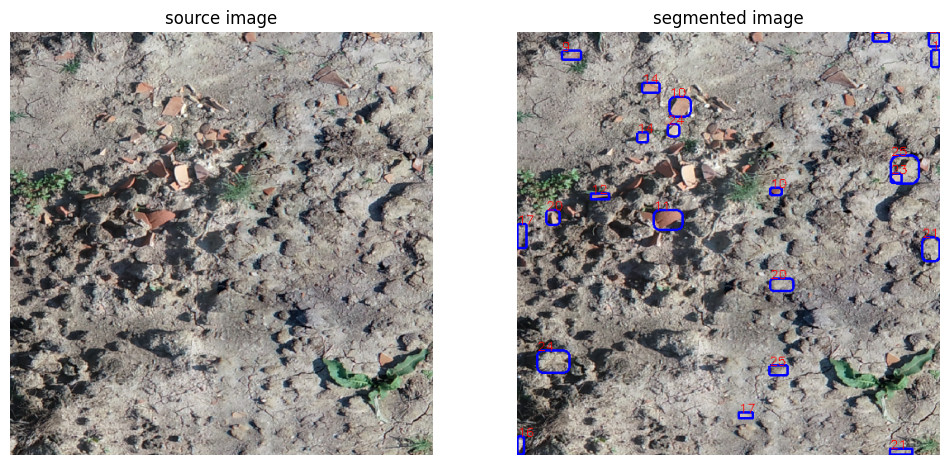

input/testApteraMiniLowres.png 1684 871 1536 0
before all filters: 54
--> filter areas (min max) = ( 22 257746 7787.185185185185 ) / below  3000 : 51
after area filter: 33
remaining after hue filter 7
before NMS 7
remaining after NMS 6


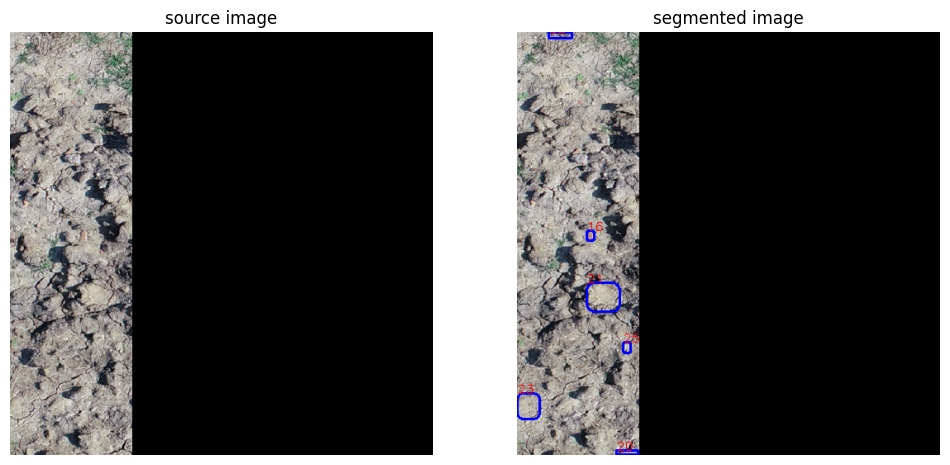

input/testApteraMiniLowres.png 1684 871 0 512
before all filters: 62
--> filter areas (min max) = ( 33 149604 4068.0967741935483 ) / below  3000 : 57
after area filter: 33
remaining after hue filter 4
before NMS 4
remaining after NMS 4


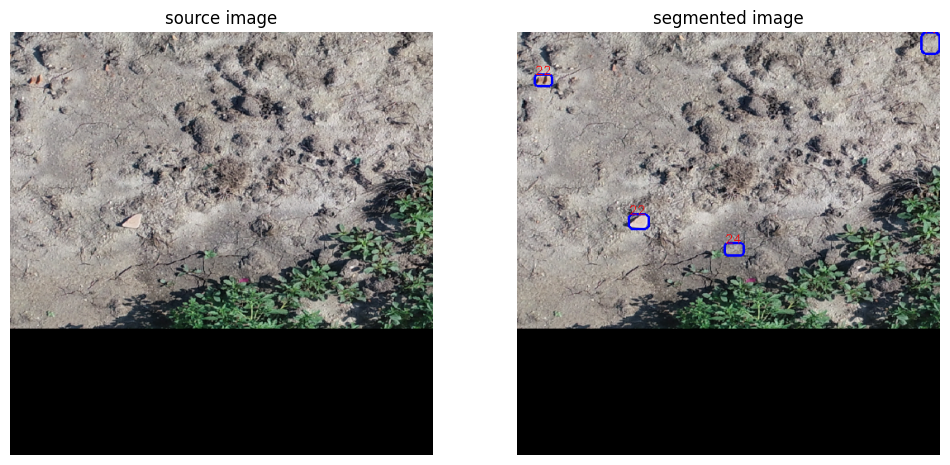

input/testApteraMiniLowres.png 1684 871 512 512
before all filters: 125
--> filter areas (min max) = ( 15 147138 3003.248 ) / below  3000 : 118
after area filter: 76
remaining after hue filter 8
before NMS 8
remaining after NMS 7


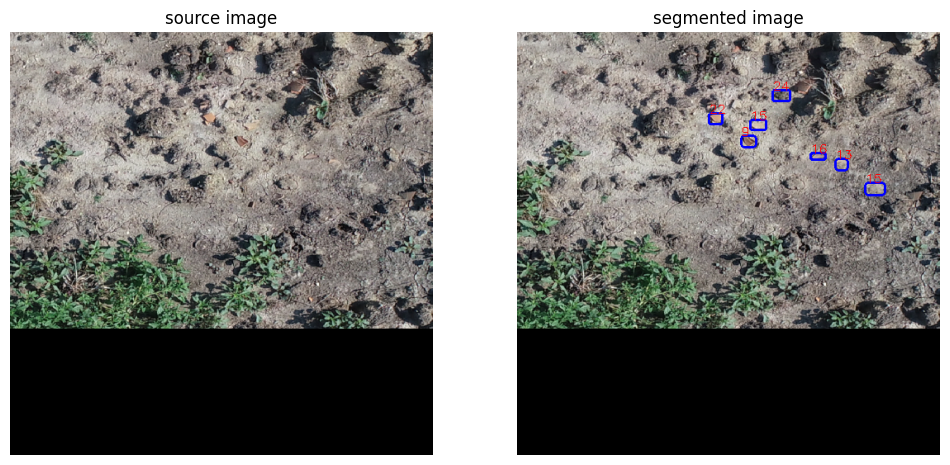

input/testApteraMiniLowres.png 1684 871 1024 512
before all filters: 138
--> filter areas (min max) = ( 16 178998 2138.6739130434785 ) / below  3000 : 136
after area filter: 100
remaining after hue filter 23
before NMS 23
remaining after NMS 21


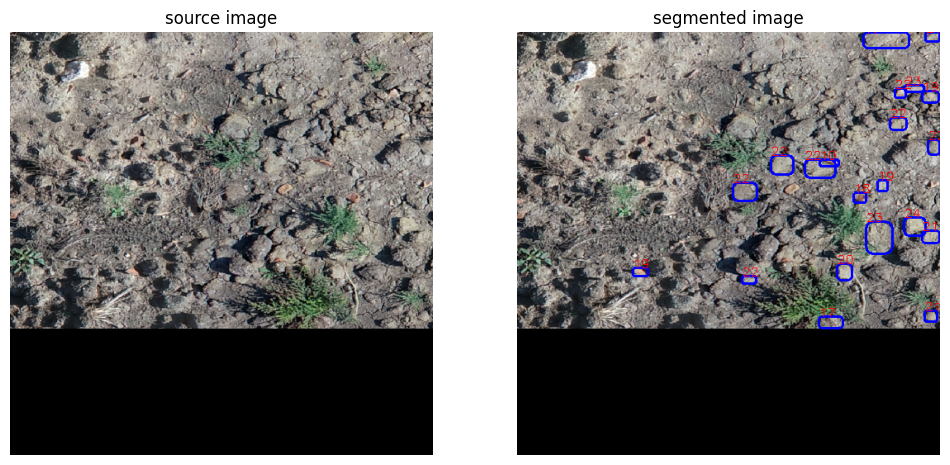

input/testApteraMiniLowres.png 1684 871 1536 512
before all filters: 20
--> filter areas (min max) = ( 29 248064 15134.9 ) / below  3000 : 17
after area filter: 11
remaining after hue filter 2
before NMS 2
remaining after NMS 2


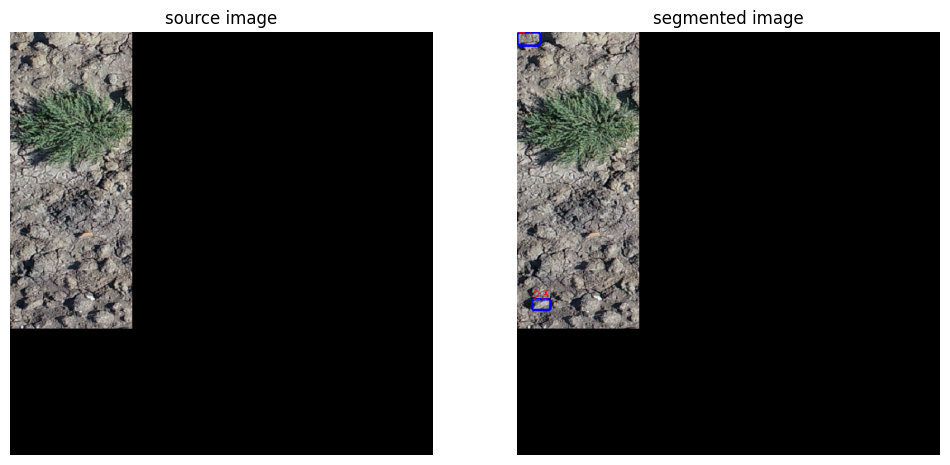

total number of sherds: # 116


In [ ]:
# this is the main loop
# we iterate over all files, then over all tiles of each file if required

for f in files:
    filepath = Path(f)
    FIRST_TIME = True
    total = 0 # total no. of detections in this file
    for tile_width, tile_height, x, y, orig_shape, tile in image_tiler(filepath):
        print ('_________________')
        print ( filepath, tile_width, tile_height, x, y)
        if FIRST_TIME: FIRST_TIME = False; annot_out = np.zeros((tile_height, tile_width, 3), dtype=np.uint8)
        image_bgr = tile
        if image_bgr.max() == 0: continue # skip empty tiles
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        sam2_result = mask_generator.generate(image_rgb)
        torch.cuda.empty_cache();gc.collect()

        # now we filter the results
        detections = filter_result(image_rgb, sam2_result, hue_range=HUE_RANGE)
        if detections:
            annot_rgb = annotatorFunc(image_rgb, detections)
            if Calibration_Mode: # add hue values
                for d in range(len(detections)):
                  cv2.putText(annot_rgb, str(detections.data['hue'][d]), tuple(map(int, detections.data['bbox'][d][:2])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0))
        else:
            annot_rgb = image_rgb # if nothing found
        if With_console_output: sv.plot_images_grid(images=[image_bgr, cv2.cvtColor(annot_rgb, cv2.COLOR_RGB2BGR)], grid_size=(1, 2), titles=['source image', 'segmented image'])
        # write result onto image
        annot_rgb = annot_rgb[0:orig_shape[0], 0:orig_shape[1]] # go back to original shape (remove padding)
        annot_out[y:y+tile.shape[0], x:x+tile.shape[1]] = annot_rgb
        total += len(detections)
        cv2.imwrite(OUTPATH/("SAM_"+filepath.name),cv2.cvtColor(annot_out, cv2.COLOR_RGB2BGR))
        #break

    print ("total number of sherds: #", total)
    if Show_number_sherds_on_output:
        cv2.putText(annot_out, "# "+str(total), (40,120), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 0), 3, cv2.LINE_AA)
        cv2.imwrite(OUTPATH/("SAM_"+filepath.name),cv2.cvtColor(annot_out, cv2.COLOR_RGB2BGR))
    #break

## Export results for download
We now open a file download dialog for the output.zip. Simply store the output in your local computer. Done :-)

In [ ]:
!zip -r output.zip output
colabfiles.download('output.zip')

  adding: output/ (stored 0%)
  adding: output/SAM_testApteraMiniLowres.png (deflated 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>